Mobile Games A/B testing
from kiggle data

Project info: Cookie Cats, a mobile game.
As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress.
where should the gates be placed? Initially the first gate was placed at level 30. In this project, we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention.

# Data Exploring and Data Cleaning

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv("D:\Studying\AB Testing\Data source\cookie_cats.csv")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# checking data 
check missing values

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


# count the number of players in each group

In [10]:
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


users were randomly assigned to either gate30 or gate40
the number of players is roughly the same in the control and test group

## user behavior
data visualisation

<AxesSubplot:>

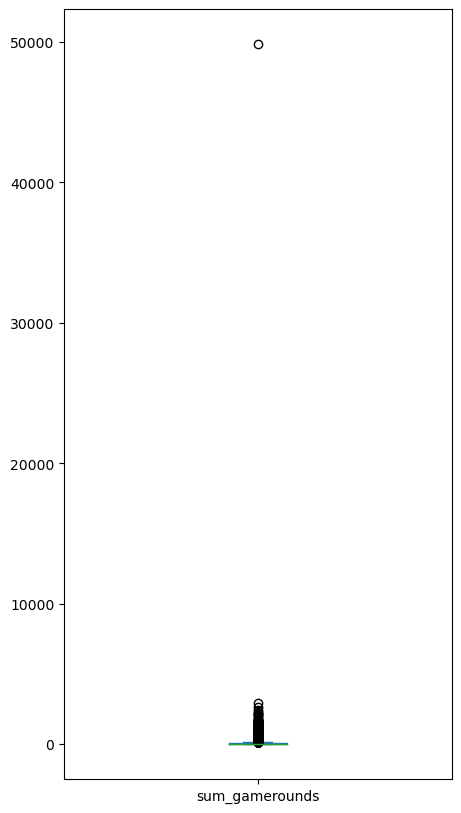

In [11]:
df['sum_gamerounds'].plot.box(figsize=(5,10))

There is an outlier. The player played 50000 game rouds during the first week. Due to the outlier, this boxplot is extremely skewed and not informative.
let check the percentile

In [12]:
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

50% of players played fewer than 16 game rounds during the first week after installation, and 75% of players played fewer than 51 rounds

In [13]:
# counting the no.of players for each no.of gamerounds
plot_df = df.groupby('sum_gamerounds')['userid'].count()
plot_df

sum_gamerounds
0        3994
1        5538
2        4606
3        3958
4        3629
         ... 
2294        1
2438        1
2640        1
2961        1
49854       1
Name: userid, Length: 942, dtype: int64

3994 players did not even play a single round after installation.
Possible reasons:
1.they attracted by other games by the same time
2.they open the app but did not like the design/interface/music etc. quit and did not play
3.have not start to play the game
4.others
more than 14000 players played fewer than 3 rounds 
Possible reasons:
1.did not enjoy/like the game
2.the game turned out to be diff from what they expected
3.the game was too easy and they got board of it
we need to know why a large no.players quit the game at an early stage
collect player feedback or in-app survey

Text(0.5, 0, '# Game rounds')

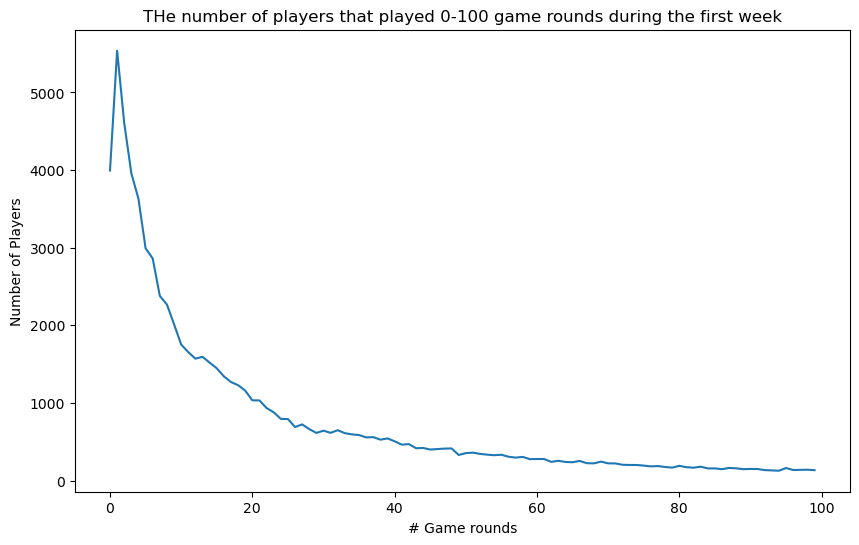

In [14]:
# plot the distribution of players that played 0-100 game rounds during first week playing the game
%matplotlib inline

ax = plot_df[:100].plot(figsize=(10,6))
ax.set_title("THe number of players that played 0-100 game rounds during the first week")
ax.set_ylabel("Number of Players")
ax.set_xlabel("# Game rounds")

The distribution is highly skewed with a long right tail.
A huge number of players played few than 20 rounds and left the game 

# Comparing 1-day retention #
The higher 1-day retention is, the easier it is to retain players and build a large player base.

In [16]:
df['retention_1'].sum()/df['retention_1'].count()

0.4452095044850259

In [17]:
df['retention_1'].mean()

0.4452095044850259

Less than half of the players come back one day after instlling the game

In [18]:
# 1 day retention for each AB testing group
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

a slightly decrease in 1-day retention when the gate was moved from gate30 to gate 40

# Bootstrapping

<AxesSubplot:ylabel='Density'>

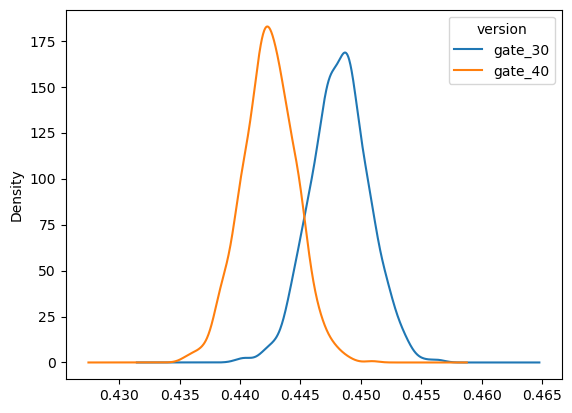

In [19]:
# creat a list with bootstrapped means for each AB group
boot_Id =[]
for i in range(1000):
    boot_mean = df.sample(frac = 1, replace = True).groupby('version')['retention_1'].mean()
    boot_Id.append(boot_mean)

# transfering the list to a dataframe
boot_Id = pd.DataFrame(boot_Id)

# A kernel density estimate plot of the bootstrap distributions
boot_Id.plot(kind='density')

Probability that 1-day rentention is greater when the gate is at level 30: 0.959


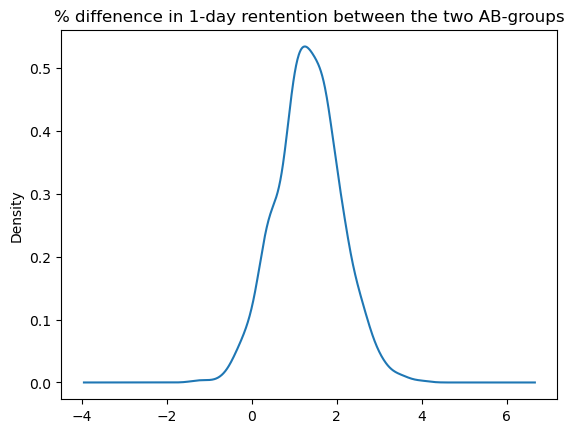

In [22]:
# plot the % diff to have a closer look
# 1. adding a column with the % diff
boot_Id['diff'] = (boot_Id.gate_30 - boot_Id.gate_40)/boot_Id.gate_40*100
# 2.plot
ax = boot_Id['diff'].plot(kind='density')
ax.set_title('% diffenence in 1-day rentention between the two AB-groups')

# 3.calculating the probability that 1-day retention is greater when the gate is at level 30
print('Probability that 1-day rentention is greater when the gate is at level 30:', (boot_Id['diff'] > 0).mean())


the most likely % difference is around 1% - 2%, 96% of the distribution > 0, in favor of a gate at level 30

# Comparing 7-day retention
since many players haven't reached level 30 in 1 day. many players won't have been affacted by the gate
After playing the game for a week, more players should have reached level 40, it's time to take look at 7-day retention

In [23]:
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

After comparing 7-day retention:
1.7-day retention is slightly lower when the gate is at level 40
2.the diff is larger than for 1-day retention
3.the overall 7-day retention is lower than the overall 1-day retention; fewer people play a game a week after installing than a day after installing

# Bootstrap: 7-day retention of AB group

In [26]:
# creat a list with bootstrapped means for each group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac = 1, replace = True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
# change list to dataframe
boot_7d = pd.DataFrame(boot_7d)
# add column with % diff
boot_7d['diff'] = (boot_7d.gate_30 - boot_7d.gate_40)/boot_7d.gate_40*100

Probability that 7-day retention is greater when the gate is at level 30: 1.0


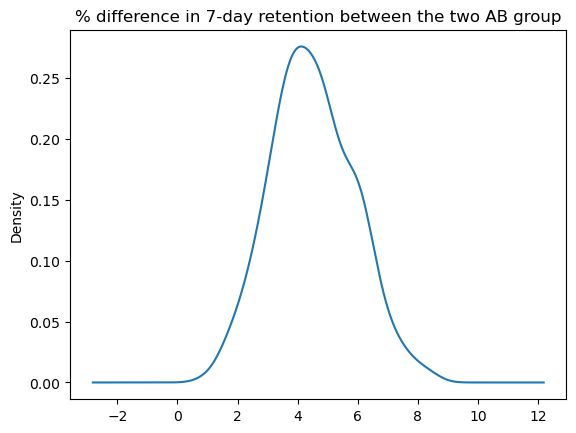

In [27]:
# Ploting the bootsrap % diff
ax = boot_7d['diff'].plot(kind='density')
ax.set_title('% difference in 7-day retention between the two AB group')

print('Probability that 7-day retention is greater when the gate is at level 30:', (boot_7d['diff'] > 0).mean())


the most likely % difference is around 1% - 8%, almost 100% of the distribution > 0, in favor of a gate at level 30

# conclusion
There is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40.
if we want to keep the retention high, we can't move the gate from level 30 to level 40
